# TSNE with new model

## Model Setup (from model.ipynb)

### Load Packages

In [1]:
# Main modules 
import torch
from torch import Generator
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from frogfunctions import Model 
from frogfunctions import setup_seed, train_loop, test_loop, train_model, plot_probabilities

In [2]:
# Dataframe output format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Set random seed for reproduction

In [3]:
SEED = 42
setup_seed(SEED)

### Import data

In [4]:
data_dir = "../data/"

In [5]:
# Download and load the training data
dataset_all = ImageFolder(data_dir, transform=torchvision.transforms.ToTensor())

# Print number in full data set
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all) = {size_all}')

# Split into Test, Validation, and Training
size_test = int(size_all * 0.10)
size_val = int(size_all * 0.10)
size_train = size_all - size_test - size_val
dataset_test, dataset_val, dataset_train = random_split(dataset_all, [size_test, size_val, size_train], 
                                                        generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into test, validation, and training: \n \
      len(dataset_test) = {len(dataset_test)} \n \
      len(dataset_val) = {len(dataset_val)} \n \
      len(dataset_train) = {len(dataset_train)}')

Before splitting the full dataset into train and test: len(dataset_all) = 700
After splitting the full dataset into test, validation, and training: 
       len(dataset_test) = 70 
       len(dataset_val) = 70 
       len(dataset_train) = 560


### Prepare data

In [6]:
# Define batch size
batch_size = 16

In [7]:
# Load data into DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

### Define parameters for model

In [8]:
# Define number of classes
num_classes = 7

In [9]:
# Create model 
model = Model(num_classes=num_classes).to(device)

In [10]:
# Define hyperparameters
learning_rate = 0.002
weight_decay = 0.005
momentum=0.09

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

### Train model

Epoch 1
-------------------------------
loss: 1.949642  [   16/  560]
Training Error: Accuracy: 23.6%
Validation Error: Accuracy: 8.6%, Avg loss: 1.935410 

Epoch 2
-------------------------------
loss: 1.910134  [   16/  560]
Training Error: Accuracy: 35.5%
Validation Error: Accuracy: 61.4%, Avg loss: 1.838374 

Epoch 3
-------------------------------
loss: 1.827402  [   16/  560]
Training Error: Accuracy: 56.4%
Validation Error: Accuracy: 62.9%, Avg loss: 1.730969 

Epoch 4
-------------------------------
loss: 1.811658  [   16/  560]
Training Error: Accuracy: 59.8%
Validation Error: Accuracy: 75.7%, Avg loss: 1.576298 

Epoch 5
-------------------------------
loss: 1.619991  [   16/  560]
Training Error: Accuracy: 69.8%
Validation Error: Accuracy: 71.4%, Avg loss: 1.409997 

Epoch 6
-------------------------------
loss: 1.407601  [   16/  560]
Training Error: Accuracy: 73.8%
Validation Error: Accuracy: 81.4%, Avg loss: 1.193287 

Epoch 7
-------------------------------
loss: 1.22876

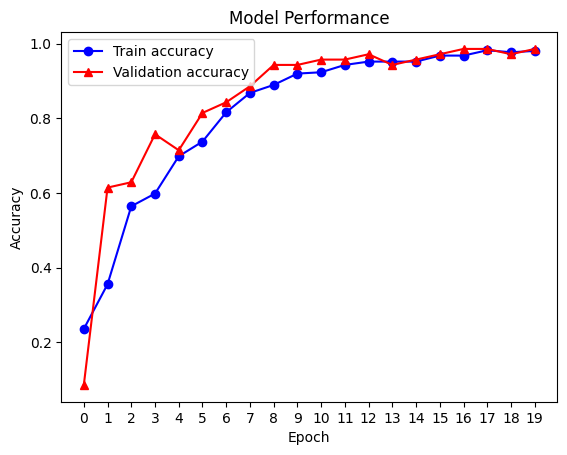

In [11]:
# Set number of epochs 
epochs = 20

# Train
train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

## Setup for TSNE

In [12]:
from time import time

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE

# !pip install ipympl
# %matplotlib widget
# %matplotlib notebook
# from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [13]:
labels = []

for batch, (X, y) in enumerate(test_dataloader):
    
    images = X.to(device)
    labels += y
 
    output = model.forward(images)
 
    current_outputs = output.cpu().detach().numpy()
    
    try:
        outputs = np.concatenate([outputs, current_outputs], axis=0)
    except NameError:
        outputs = current_outputs

In [20]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
def TSNE_2D(tsne, scale=True, save=False):
    
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    if scale:
        tx = scale_to_01_range(tx)
        ty = scale_to_01_range(ty)
    
    colors_per_class = {0:0, 1 : 1, 2: 2, 3:3, 4:4, 5:5, 6:6}
    

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    class_to_name = {0: 'Upper Amazon tree frog', 
                                  1: 'Demerara Falls tree frog',
                                  2: 'Chirping Robber frog',
                                  3: "Vanzolini's Amazon frog",
                                  4: "South American common toad",
                                  5: "Peters' dwarf frog",
                                  6: 'Background'}

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        
        indices = [i for i, l in enumerate(labels) if l == label]

        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        ax.scatter(current_tx, current_ty, label=class_to_name[label]) 

    ax.legend(loc='best')
    
    if save:
        fig.savefig("tsne_2d.png")

    # finally, show the plot
    plt.show()
    
def TSNE_3D(tsne, angle=[45, 45], scale=True):
    
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tz = tsne[:, 2]

    if scale:
        tx = scale_to_01_range(tx)
        ty = scale_to_01_range(ty)
        tz = scale_to_01_range(tz)
    
    colors_per_class = {0:0, 1 : 1, 2: 2, 3:3, 4:4, 5:5, 6:6}
    
    class_to_name = {0: 'Upper Amazon tree frog', 
                                  1: 'Demerara Falls tree frog',
                                  2: 'Chirping Robber frog',
                                  3: "Vanzolini's Amazon frog",
                                  4: "South American common toad",
                                  5: "Peters' dwarf frog",
                                  6: 'Background'}

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        
        indices = [i for i, l in enumerate(labels) if l == label]

        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        current_tz = np.take(tz, indices)

        ax.scatter(current_tx, current_ty, current_tz, label=class_to_name[label]) 

    ax.legend(loc='best')
    ax.view_init(angle[0], angle[1])

    # finally, show the plot
    plt.show()

## 2D TSNE

In [15]:
tsne = TSNE(n_components=2).fit_transform(outputs)

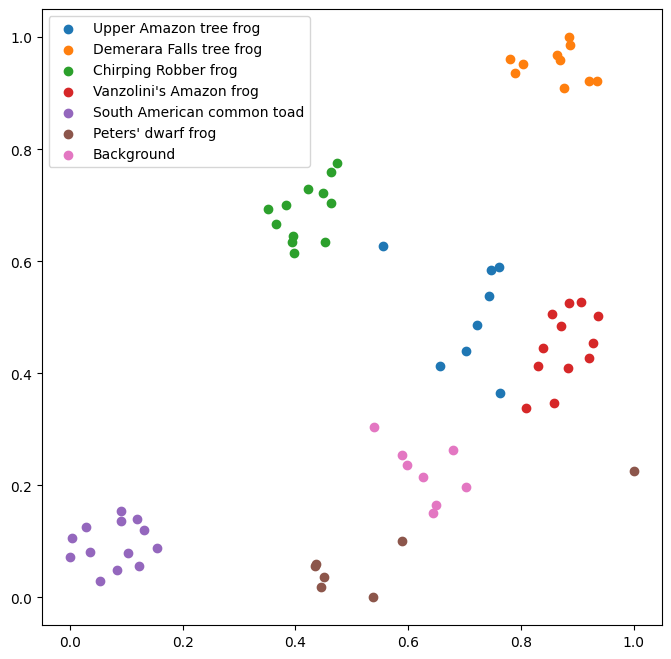

In [19]:
TSNE_2D(tsne, save=True)

## 3D TSNE

In [21]:
tsne_3d = TSNE(n_components=3).fit_transform(outputs)

/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


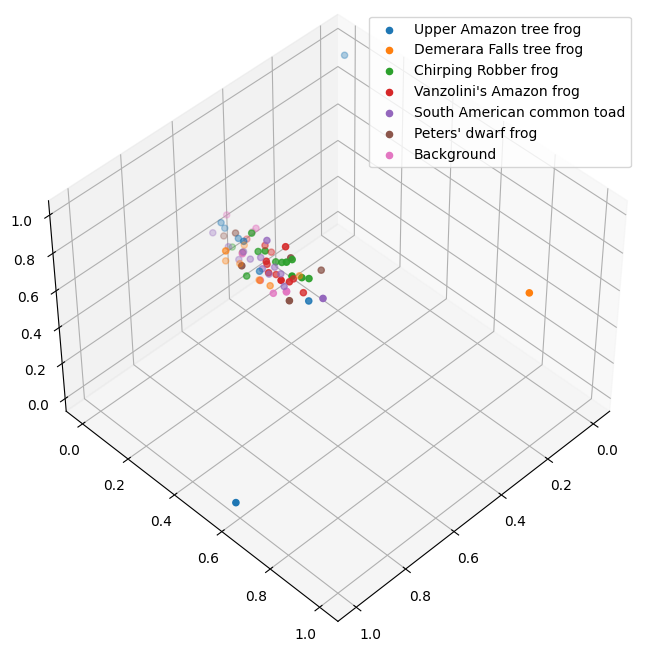

In [22]:
TSNE_3D(tsne_3d)

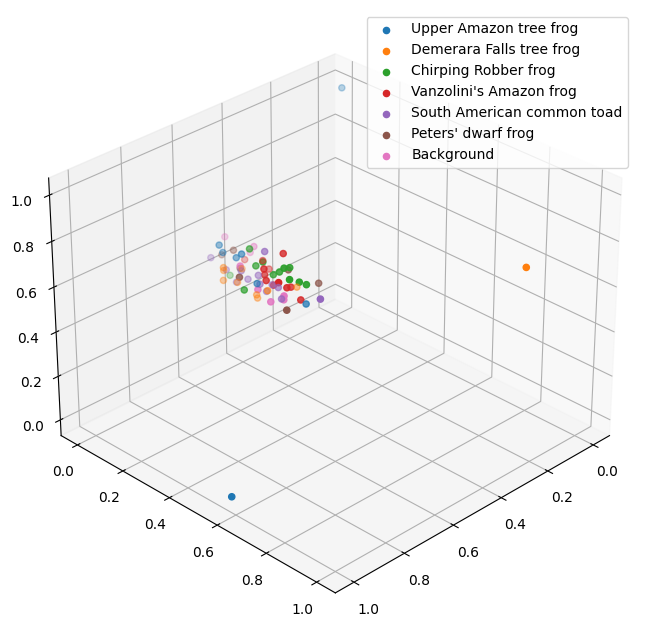

In [28]:
TSNE_3D(tsne_3d, angle=[30, 45])